## SVD DMR: wav file alignment

In [38]:
import os
import torch, torchvision
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from pystoi import stoi

In [40]:
# %matplotlib notebook
# %matplotlib inline

#### Machine paths

In [41]:
path = "/home/david/sigMF_ML/RF_SVD/clean_speech/IQ_files/dmr_aligned/" # ace
path_save = "/home/david/sigMF_ML/RF_SVD/clean_speech/IQ_files/stoi_save/" # ace
print(path)

/home/david/sigMF_ML/RF_SVD/clean_speech/IQ_files/dmr_aligned/


#### reading sigmf meta data and encoder function

In [42]:
def calculate_sdr(source_signal, estimated_signal, offset=None, scale_invariant=True):
    # For regular SDR, set “scale_invariant” to False, for SISDR, set it to True.
    s = source_signal
    y = estimated_signal
    # add a batch axis if non-existant
    if len(s.shape) != 2:
        s = s.unsqueeze(0)
        y = y.unsqueeze(0)
    # truncate all signals in the batch to match the minimum-length
    min_length = min(s.shape[-1], y.shape[-1])
    s = s[..., :min_length]
    y = y[..., :min_length]
    if scale_invariant:
        alpha = s.mm(y.T).diag()
        alpha /= ((s ** 2).sum(dim=1) + eps)
        alpha = alpha.unsqueeze(1)  # to allow broadcasting
    else:
        alpha = 1
    e_target = s * alpha
    e_res = e_target - y
    numerator = (e_target ** 2).sum(dim=1)
    denominator = (e_res ** 2).sum(dim=1) + eps
    sdr = 10 * torch.log10((numerator / denominator) + eps)
    # if `offset` is non-zero, this function returns the relative SDR
    # improvement for each signal in the batch
    if offset is not None:
        sdr -= offset
    return sdr

In [43]:
print(path)
os.chdir(path)

/home/david/sigMF_ML/RF_SVD/clean_speech/IQ_files/dmr_aligned/


In [44]:
eps = np.finfo(np.float32).eps

In [45]:
# clean, fs = sf.read(path+'original_clean_aligned.wav')
# clean, fs = sf.read(path+'1914-133440-0016.flac')
clean, fs = sf.read(path+'dmr_orig_aligned.wav')
c = len(clean)
original_clean = clean
original_c = c
# print('clean length = ', c)
# print('fs original = ', fs)
rank_list = [5,6,7,8,9,10,26,100,500,1000]
d1 = np.zeros(len(rank_list), dtype = float)
SNR_calc = np.zeros(len(rank_list), dtype = float)
m = 0
# print('d1 = ', d1)
for i in rank_list:
#     print('rank =', i)
    if (i != 1000):
        fullpath =path+'dmr_svd'+'{0:02d}'.format(i)+'_aligned.wav'
        denoised, fs = sf.read(fullpath)
        de = len(denoised)
#         print('de length = ', de)
        if c > de:
            clean = clean[0:de]
#             print('clean new length = ', len(clean))
        else:
            denoised = denoised[0:c]
#             print('denoised new length = ', len(denoised))
        # Clean and den should have the same length, and be 1D
        d1[m] = stoi(clean, denoised, fs, extended=False)
        SNR_calc[m] = calculate_sdr(torch.Tensor(clean), torch.Tensor(denoised))
    elif (i == 1000): # This is the full vector - NO SVD
        denoised, fs = sf.read(path+'dmr_orig_aligned.wav')
        de = len(denoised)
        if c > de:
            clean = clean[0:de]
        else:
            denoised = denoised[0:c]
    d1[m] = stoi(clean, denoised, fs, extended=False)
    SNR_calc[m] = calculate_sdr(torch.Tensor(clean), torch.Tensor(denoised))
    m=m+1
    clean = original_clean
    c = original_c

In [46]:
num =6
np.asarray(rank_list[:num])

array([ 5,  6,  7,  8,  9, 10])

In [47]:
d1[:num]

array([0.7607767 , 0.78004886, 0.78113397, 0.78029317, 0.77611993,
       0.78766724])

In [48]:
num = 6
os.chdir(path_save)
np.save('rank_list_dmr', np.asarray(rank_list[:num]))
np.save('dmr', d1[:num])   

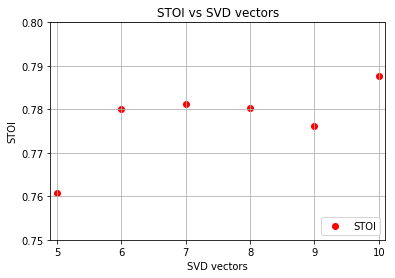

In [49]:
plt.figure(figsize=(9, 6))
fig = plt.figure()
plt.scatter(rank_list,d1,c='r', label='STOI')
plt.legend(loc='lower right')
plt.title('STOI vs SVD vectors')
plt.xlabel('SVD vectors')
plt.ylabel('STOI')
plt.ylim(.75, .80)
plt.xlim(4.9, 10.1)
plt.grid()
fig.savefig('dmr_stoi.pdf', format="pdf")
plt.show()

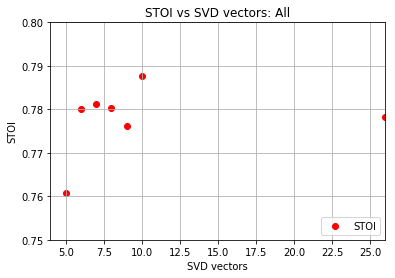

In [50]:
plt.figure(figsize=(9, 6))
fig2 = plt.figure()
plt.scatter(rank_list,d1,c='r', label='STOI')
plt.legend(loc='lower right')
plt.title('STOI vs SVD vectors: All')
plt.xlabel('SVD vectors')
plt.ylabel('STOI')
plt.ylim(.75, .8)
plt.xlim(4, 26)
plt.grid()
fig2.savefig('dmr_stoi_all.png', format="png")
plt.show()